# Toxic Comment Classification 

* Get Data from [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

In [57]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dot, Reshape
from keras.layers import Input, LSTM, GRU, Bidirectional, Dense
from keras.models import Model
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.callbacks import Callback
from keras.optimizers import Adam, SGD
import keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [36]:
def get_toxic_data(file_name):
    train = pd.read_csv(file_name)
    sentences = train["comment_text"].fillna("DUMMY_VALUE").values
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    targets = train[labels].values
    return sentences, labels, targets

In [37]:
def get_toxic_testing_data(file_name):
    train = pd.read_csv(file_name)
    sentences = train["comment_text"].fillna("DUMMY_VALUE").values
    return sentences

In [38]:
toxic_train_file_path = 'data/train.csv'
toxic_test_file_path = 'data/test.csv'

In [161]:
train_sentences, labels, train_targets = get_toxic_data(toxic_train_file_path)

In [162]:
test_sentences = get_toxic_testing_data(toxic_test_file_path)

In [163]:
max_vocab_size = 30000

In [164]:
tokenizer = Tokenizer(num_words=max_vocab_size, lower=True)
tokenizer.fit_on_texts(sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# IMPORTANT
#  1. the index starts from 1 instead of 0
#  2. the word index dictionary does not honor the number of words constraint
word2index = tokenizer.word_index

In [165]:
print(len(word2index))

210337


In [166]:
l = [len(seq) for seq in train_sequences]
print(len(train_sequences))
print(min(l))
print(max(l))
print(np.mean(l))

159571
0
1400
66.12617580888758


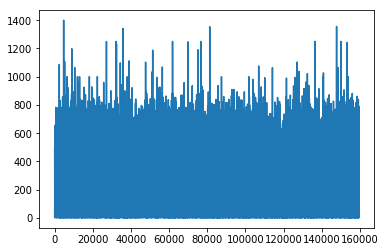

In [167]:
plt.plot(l)
plt.show()

In [14]:
def get_word2vec(file_name):
    word2vec = {}
    with open(file_name, encoding='utf8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            vec = np.asarray(values[1:], dtype=np.float32)
            word2vec[word] = vec
    return word2vec

In [15]:
# Get glove data from https://nlp.stanford.edu/data/
# word2vec_file_path = 'data/glove.6B.50d.txt'
word2vec_file_path = 'data/glove.840B.300d.txt'

In [16]:
word2vec = get_word2vec(word2vec_file_path)

In [168]:
max_squence_length = 150

In [169]:
train_data = pad_sequences(train_sequences, maxlen=max_squence_length)
print(train_data.shape)

(159571, 150)


In [170]:
test_data = pad_sequences(test_sequences, maxlen=max_squence_length)
print(test_data.shape)

(153164, 150)


## Model

In [212]:
# embedding_dim = 50
embedding_dim = 300

print(max_vocab_size)
print(len(word2index))
num_vocab = min(max_vocab_size + 1, len(word2index) + 1)
print(num_vocab)

30000
210337
30001


In [213]:
embedding_matrix = np.zeros((num_vocab, embedding_dim))
for word, index in word2index.items():
    if index <= max_vocab_size:
        vec = word2vec.get(word)
        if vec is not None:
            embedding_matrix[index] = vec

In [214]:
print(embedding_matrix.shape)

(30001, 300)


In [215]:
# type(data)
# train_data = data[:150000]
# test_data = data[150000:]
# train_targets = targets[:150000]
# test_targets = targets[150000:]
# print(train_data.shape)
# print(test_data.shape)
# print(train_targets.shape)
# print(test_targets.shape)

In [216]:
embedding = Embedding(
            embedding_matrix.shape[0],
            embedding_matrix.shape[1],
            weights = [embedding_matrix],
            input_length=max_squence_length,
            trainable=True,    
            name='encoder_embed')

In [217]:
latent_dim = 128

In [218]:
encoder_input_placeholder = Input(shape=(max_squence_length,), name = 'encoder_inputs')
encoder_input_x = embedding(encoder_input_placeholder)

encoder_lstm = Bidirectional(GRU(latent_dim, return_sequences=True, dropout=0.4), name='encoder_bidirectional_lstm')

encoder_lstm_outputs = encoder_lstm(encoder_input_x)

In [219]:
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

In [220]:
x = Dense(10, activation='relu', name='attn_weights_dense_1')(encoder_lstm_outputs)
alphas = Dense(1, activation=softmax_over_time, name='attn_weights_dense_2')(x)
encoding = Dot(axes=1,name='attn_dot_layer')([alphas, encoder_lstm_outputs])

output = Dense(len(labels), activation='sigmoid')(encoding)

output = Reshape((len(labels),))(output)

model = Model(encoder_input_placeholder, output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 150)          0                                            
__________________________________________________________________________________________________
encoder_embed (Embedding)       (None, 150, 300)     9000300     encoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_bidirectional_lstm (Bid (None, 150, 256)     329472      encoder_embed[0][0]              
__________________________________________________________________________________________________
attn_weights_dense_1 (Dense)    (None, 150, 10)      2570        encoder_bidirectional_lstm[0][0] 
__________________________________________________________________________________________________
attn_weigh

In [221]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

## Train Model

In [222]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [223]:
file_path = 'data/model.best.hdf5'

X_tra, X_val, y_tra, y_val = train_test_split(train_data, train_targets, train_size=0.9, random_state=233)

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=4)
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val,checkpoint, early]

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [224]:
# validation_split = 0.1
batch_size = 512
epochs = 10

r = model.fit(X_tra, y_tra, batch_size=batch_size, epochs = epochs, validation_data=(X_val, y_val), callbacks = callbacks_list, verbose=1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 2337s 16ms/step - loss: 0.0569 - acc: 0.9786 - val_loss: 0.0448 - val_acc: 0.9832

 ROC-AUC - epoch: 1 - score: 0.985816

Epoch 00001: val_acc improved from -inf to 0.98317, saving model to data/model.best.hdf5
Epoch 2/10
143613/143613 [==============================] - 2552s 18ms/step - loss: 0.0390 - acc: 0.9848 - val_loss: 0.0452 - val_acc: 0.9829

 ROC-AUC - epoch: 2 - score: 0.984560

Epoch 00002: val_acc did not improve from 0.98317
Epoch 3/10
143613/143613 [==============================] - 2740s 19ms/step - loss: 0.0335 - acc: 0.9867 - val_loss: 0.0503 - val_acc: 0.9819

 ROC-AUC - epoch: 3 - score: 0.982812

Epoch 00003: val_acc did not improve from 0.98317
Epoch 4/10
143613/143613 [==============================] - 2544s 18ms/step - loss: 0.0296 - acc: 0.9883 - val_loss: 0.0544 - val_acc: 0.9814

 ROC-AUC - epoch: 4 - score: 0.981401

Epoch 00004: val_acc did not imp

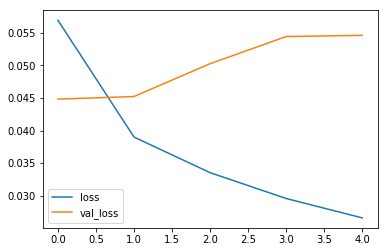

In [225]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

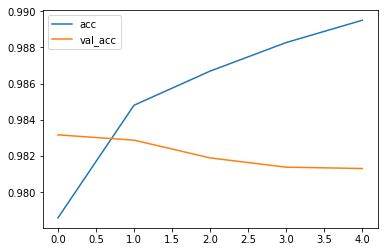

In [226]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

The model is overfit

In [227]:
#Loading model weights
model.load_weights(file_path)
print('Predicting....')
y_pred = model.predict(test_data, batch_size=1024,verbose=1)

Predicting....
153164/153164 [==============================] - 624s 4ms/step


In [228]:
print(y_pred[0])

[0.9984561  0.42819512 0.9939387  0.08446565 0.9744417  0.1871997 ]


In [229]:
submission = pd.read_csv('data/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('data/submission.csv', index=False)

The test accuracy is 0.9810

### Interesting Implementation

* [bidirectional-gru-with-convolution](https://www.kaggle.com/eashish/bidirectional-gru-with-convolution/code)
* [capsule-net-with-gru](https://www.kaggle.com/chongjiujjin/capsule-net-with-gru/code)